# Gold Comparison Capstone: Part 1 - Data Wrangling

For this capstone I have collected a total of five different csv files. They are:
1. "Barrick Gold Corp 1985-2020.csv"
2. "gold-price-last-ten-years.csv"
3. "BTC-USD 2014-2020.csv"
4. "silver history.csv"
5. "SP500 2007-2020.csv"

The purpose of this capstone is to conduct a small scale test of the hypothesis that when the stock market goes down in value (represented by the S&P500 index), the value of gold increases. To test this further, I have included several other sets of data: the value of silver, the stock value of Barrick Gold Corp (a gold mining company), and the value of Bitcoin to the US dollar.

Null Hypothesis: S&PP 500 index value dropping will not have a statistically significant positive effect on the stock value of Gold.

The reasoning for including silver is to see if this trend is unique to gold, or if other precious metals increase in value as the stock market declines. 

The stock value of Barrick Gold Corp. is included in order to see if the stock value of gold mining companies also increases in value in correlation to the value of gold and the S&P500 index. 

Finally, Bitcoin has been included simply because of its volatile nature in comparison to the rest of the values.

The final test for this data will be to construct a train/test pipeline that attempts to accurately predict the value of gold depending on the value of the other stocks and indexes provided.

To begin, I will clean the data in order to properly merge and compare it in a single dataframe.

In [1]:
# To begin, I will import the "gold-price-last-ten-years.csv," and "SP500 2007-2020.csv" 
# in order to merge them together along the date column.

import pandas as pd # for importing, reading, cleaning csv files
import numpy as np # for maths, of course
import matplotlib.pyplot as plt # so we can plot
import seaborn as sns # so we can beautify the plots
import statsmodels.api as sm # supports specifying models using R-style formulas and Pandas DataFrame.
from statsmodels.graphics.api import abline_plot # For visualizing and evaluating predictions
from sklearn.metrics import mean_squared_error, r2_score # Functions to measure regression performance
from sklearn.model_selection import train_test_split # For splitting data effectively
from sklearn import linear_model, preprocessing # For linear model functions and scaling, centering, normalizing,
import warnings # For handling error messages.
# Don't worry about the following two instructions: they just suppress warnings that could occur later. 

path = 'C:\\Users\\mccal\\Desktop\\Springboard Files\\Springboard Capstone data\\BTG Capstone\\'

# There is a lot of text prior to the actual columns, so the header has \
# been set appropriatley.
gold = pd.read_csv('gold-price-last-ten-years.csv', sep=',', header=8)

gold.head()

,date,value
0,2010-08-25,1237.50
1,2010-08-26,1240.25
2,2010-08-27,1234.50
3,2010-08-31,1233.50
4,2010-09-01,1250.00


In [2]:
# First things first, change 'date' column to actual date 
# format with 'pd.to_datetime()'
gold['date']=pd.to_datetime(gold['date'])

# Remove the dates we don't care aout from the data.
focus = (gold['date'] > '2014-09-16') & (gold['date'] <= '2020-08-21')

gold = gold.loc[focus]

gold.head()

,date,value
1025,2014-09-17,1236.5
1026,2014-09-18,1223.0
1027,2014-09-19,1222.5
1028,2014-09-22,1214.0
1029,2014-09-23,1225.0


In [3]:
# Renaming the columns to something more 'formal' helps me visualize 
# the final plot and table I have in mind.
gold.columns = ['Date', 'GLD(USD)']
gold.head()

,Date,GLD(USD)
1025,2014-09-17,1236.5
1026,2014-09-18,1223.0
1027,2014-09-19,1222.5
1028,2014-09-22,1214.0
1029,2014-09-23,1225.0


In [4]:
# We are going to be checking for NaN values in the data quite 
# frequently in order to monitor changes and loss of data as we clean. 
# Best to write a function for checking NaN now and speed things up! Let's
# have a function that gives us the percentage that NaN values make up in 
# the data.
def show_na(df):
    na_df = pd.concat([df.isnull().sum(), 100 * df.isnull().mean()], axis=1)
    na_df.columns=['count', '%']
    na_df.sort_values(by='count', ascending = False)
    return na_df
# Use the function
show_na(gold)

#Sweet, no Nan's thus far.

,count,%
Date,0,0.0
GLD(USD),0,0.0


Now that I have imported and sorted Gold(GLD), it's time to bring in a second dataframe and begin merging them together. 
Each of the dataframes I have for this project have different start dates, but they all have the same end date. So, in order to have consistency across all of the data, I am going to import the Bitcoin(BTC) dataframe next, as it has the most recent start date of 09-17-2014.
Then I will merge BTC along the 'Date' column of our main dataframe. This way the dataframe will only keep the dates which they share.

In [5]:
# Import the Bitcoin csv as BTC 
BTC = pd.read_csv('BTC-USD 2014-2020.csv')
BTC.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2014-09-17,465.864014,468.174011,452.421997,457.334015,457.334015,21056800.0
1,2014-09-18,456.859985,456.859985,413.104004,424.440002,424.440002,34483200.0
2,2014-09-19,424.102997,427.834991,384.532013,394.795990,394.795990,37919700.0
3,2014-09-20,394.673004,423.295990,389.882996,408.903992,408.903992,36863600.0
4,2014-09-21,408.084991,412.425995,393.181000,398.821014,398.821014,26580100.0


In [6]:
# Since we are only concerned with the closing value, we will drop the other
# columns and keep only 'Date,' and 'Adj Close,' columns.
BTC = BTC[['Date', 'Adj Close']]
BTC.columns = ['Date', 'BTC(USD)']

# Just to be sure before we do our first merge, I set the time frame that we
# care about again.
focus = (BTC['Date'] > '2014-09-16') & (BTC['Date'] <= '2020-08-21')

BTC = BTC.loc[focus]

BTC.head()

,Date,BTC(USD)
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [7]:
# Don't forget to convert the 'Date' column with pd.to_datetime()
BTC['Date']=pd.to_datetime(BTC['Date'])
BTC.head()

,Date,BTC(USD)
0,2014-09-17,457.334015
1,2014-09-18,424.440002
2,2014-09-19,394.795990
3,2014-09-20,408.903992
4,2014-09-21,398.821014


In [8]:
# Check for Nan
show_na(BTC)

,count,%
Date,0,0.000000
BTC(USD),1,0.046168


In [9]:
# Let's forward fill (ffill) that one Nan.
BTC = BTC.fillna(axis=0, method='ffill')

In [10]:
# Now, we are going to have a single dataframe upon which we merge 
# all others. So rename 'BTC' to 'maindf,' and merge the 'gold'
# on the shared 'Date' column so that the dates column is retained 
# and the only Nan's generated will be  in the value columns. Merging
# into 'maindf' also gurantees that the original dataframes are kept 
# after the merge.
maindf=BTC.merge(gold, how='left', on='Date')
maindf.head()

,Date,BTC(USD),GLD(USD)
0,2014-09-17,457.334015,1236.5
1,2014-09-18,424.440002,1223.0
2,2014-09-19,394.795990,1222.5
3,2014-09-20,408.903992,NaN
4,2014-09-21,398.821014,NaN


So, first thing I notice is new Nan's, which means that there were new dates added. This makes sense as Bitcoin is traded all day, every day and the stock market is closed on weekends and certain holidays. So, with that said, we should have about 30% Nan values in the Gold data set. We  will address this at the end. 

In [11]:
# Check for Nan
show_na(maindf)

,count,%
Date,0,0.00000
BTC(USD),0,0.00000
GLD(USD),652,30.10157


In [12]:
# Import the next csv and repeat
sp500=pd.read_csv('SP500 2007-2020.csv', sep=',', header=7)
sp500.head()

,date,value
0,2007-08-27,1466.79
1,2007-08-28,1432.36
2,2007-08-29,1463.76
3,2007-08-30,1457.64
4,2007-08-31,1473.99


In [13]:
sp500['date'] = pd.to_datetime(sp500['date'])
sp500.head()

,date,value
0,2007-08-27,1466.79
1,2007-08-28,1432.36
2,2007-08-29,1463.76
3,2007-08-30,1457.64
4,2007-08-31,1473.99


In [14]:
# Rename columns for appropriate representation.
sp500.columns = ['Date', 'S&P500(USD)']
sp500.head()

,Date,S&P500(USD)
0,2007-08-27,1466.79
1,2007-08-28,1432.36
2,2007-08-29,1463.76
3,2007-08-30,1457.64
4,2007-08-31,1473.99


In [15]:
# Since GLD and S&P500 are both stock indexes, 
# they should have almost identical Nan's.
maindf=maindf.merge(sp500, how='left', on='Date')
maindf

,Date,BTC(USD),GLD(USD),S&P500(USD)
0,2014-09-17,457.334015,1236.50,2001.57
1,2014-09-18,424.440002,1223.00,2011.36
2,2014-09-19,394.795990,1222.50,2010.40
3,2014-09-20,408.903992,NaN,NaN
4,2014-09-21,398.821014,NaN,NaN
...,...,...,...,...
2161,2020-08-17,12254.402344,1949.85,3381.99
2162,2020-08-18,11991.233398,2005.15,3389.78
2163,2020-08-19,11758.283203,1993.15,3374.85
2164,2020-08-20,11878.372070,1928.05,3385.51


In [16]:
show_na(maindf)

,count,%
Date,0,0.000000
BTC(USD),0,0.000000
GLD(USD),652,30.101570
S&P500(USD),672,31.024931


In [17]:
barrick = pd.read_csv('Barrick Gold Corp 1985-2020.csv', sep=',', header=9)

barrick.head(5)

,date,open,high,low,close,volume
0,1985-02-04,1.9985,2.1025,1.9985,1.9985,50400
1,1985-02-05,1.9985,2.2065,1.9985,1.9985,18400
2,1985-02-06,2.1025,2.3648,2.1025,2.1025,65600
3,1985-02-07,2.1025,2.2065,2.1025,2.1025,40000
4,1985-02-08,2.1025,2.2065,2.1025,2.1025,25600


In [18]:
barrick['date'] = pd.to_datetime(barrick['date'])
barrick = barrick[['date', 'close']]

In [19]:
barrick.columns = ['Date','GOLD(USD)']
barrick.head()

,Date,GOLD(USD)
0,1985-02-04,1.9985
1,1985-02-05,1.9985
2,1985-02-06,2.1025
3,1985-02-07,2.1025
4,1985-02-08,2.1025


In [20]:
maindf = maindf.merge(barrick, how='left', on='Date')
maindf.head()

,Date,BTC(USD),GLD(USD),S&P500(USD),GOLD(USD)
0,2014-09-17,457.334015,1236.5,2001.57,15.5009
1,2014-09-18,424.440002,1223.0,2011.36,15.2624
2,2014-09-19,394.795990,1222.5,2010.40,14.9285
3,2014-09-20,408.903992,NaN,NaN,NaN
4,2014-09-21,398.821014,NaN,NaN,NaN


In [21]:
show_na(maindf)

,count,%
Date,0,0.000000
BTC(USD),0,0.000000
GLD(USD),652,30.101570
S&P500(USD),672,31.024931
GOLD(USD),672,31.024931


In [22]:
silver = pd.read_csv('silver history.csv', sep=',', header=7)
silver.head()

,date,value
0,2007-08-28,11.83
1,2007-08-29,11.80
2,2007-08-30,11.86
3,2007-08-31,11.95
4,2007-09-03,12.10


In [23]:
silver['date']=pd.to_datetime(silver['date'])
silver.head()

,date,value
0,2007-08-28,11.83
1,2007-08-29,11.80
2,2007-08-30,11.86
3,2007-08-31,11.95
4,2007-09-03,12.10


In [24]:
silver.columns = ['Date', 'SLV(USD)']
silver.head()

,Date,SLV(USD)
0,2007-08-28,11.83
1,2007-08-29,11.80
2,2007-08-30,11.86
3,2007-08-31,11.95
4,2007-09-03,12.10


In [25]:
maindf = maindf.merge(silver, how='left', on='Date')
maindf.head()

,Date,BTC(USD),GLD(USD),S&P500(USD),GOLD(USD),SLV(USD)
0,2014-09-17,457.334015,1236.5,2001.57,15.5009,18.63
1,2014-09-18,424.440002,1223.0,2011.36,15.2624,18.50
2,2014-09-19,394.795990,1222.5,2010.40,14.9285,18.45
3,2014-09-20,408.903992,NaN,NaN,NaN,NaN
4,2014-09-21,398.821014,NaN,NaN,NaN,NaN


In [26]:
show_na(maindf)

,count,%
Date,0,0.000000
BTC(USD),0,0.000000
GLD(USD),652,30.101570
S&P500(USD),672,31.024931
GOLD(USD),672,31.024931
SLV(USD),647,29.870729


In [27]:
# Check for duplicate dates before setting index on "Date"
maindf['Date'].value_counts().head()

2016-11-14    1
2019-09-16    1
2017-08-28    1
2015-10-21    1
2016-12-11    1
Name: Date, dtype: int64

In [28]:
#Set index to 'Date'  for graphing and visualization
maindf= maindf.set_index('Date')
maindf.head()

,BTC(USD),GLD(USD),S&P500(USD),GOLD(USD),SLV(USD)
Date,,,,,
2014-09-17,457.334015,1236.5,2001.57,15.5009,18.63
2014-09-18,424.440002,1223.0,2011.36,15.2624,18.50
2014-09-19,394.795990,1222.5,2010.40,14.9285,18.45
2014-09-20,408.903992,NaN,NaN,NaN,NaN
2014-09-21,398.821014,NaN,NaN,NaN,NaN


In [29]:
# Now, to deal with the Nan's. The best option I propose is to forward fill
# the missing values since the values do not change much over the weekends.
# Lets be careful though and observe the mean, std deviation, etc of each
# column before we use ffill.
maindf.describe()

,BTC(USD),GLD(USD),S&P500(USD),GOLD(USD),SLV(USD)
count,2166.000000,1514.000000,1494.000000,1494.000000,1519.000000
mean,4319.095491,1310.203666,2496.003246,14.822713,16.590012
std,4095.257714,170.517162,404.167387,4.621470,1.825305
min,178.102997,1049.600000,1829.080000,5.751500,11.772000
25%,430.568237,1208.462500,2099.147500,12.141925,15.399500
50%,3564.492798,1271.400000,2471.075000,13.940050,16.510000
75%,7804.194214,1335.600000,2823.647500,17.337500,17.399500
max,19497.400391,2061.500000,3397.160000,30.130000,29.261000


In [30]:
# Now use ffill to remove the Nan's
maindf = maindf.fillna(axis=0, method='ffill')

In [31]:
# Lets look at the overall summary of each column again.
maindf.describe()

,BTC(USD),GLD(USD),S&P500(USD),GOLD(USD),SLV(USD)
count,2166.000000,2166.000000,2166.000000,2166.000000,2166.000000
mean,4319.095491,1310.235249,2495.562004,14.799460,16.567624
std,4095.257714,170.160135,403.820978,4.591783,1.787316
min,178.102997,1049.600000,1829.080000,5.751500,11.772000
25%,430.568237,1207.700000,2099.060000,12.139200,15.392000
50%,3564.492798,1271.400000,2471.875000,13.887600,16.480500
75%,7804.194214,1335.775000,2823.647500,17.326875,17.382000
max,19497.400391,2061.500000,3397.160000,30.130000,29.261000


So using ffill had no significant impact on the std dev or mean for any of the columns. We can see that the strongest change was probably to silver, with its std dev going from 1.825 to 1.787.  Still, not significant. 

In [32]:
# Double  check, but there should't be any  nan values now.
maindf.isnull().sum()

BTC(USD)       0
GLD(USD)       0
S&P500(USD)    0
GOLD(USD)      0
SLV(USD)       0
dtype: int64

Sweet, so everything is clean now. No duplicate dates and no NaN  values. Now lets finally take a look to see if there  is any correlation among these datasets. Lets first look at a timeline graph of all the columns to see if anything stands out.

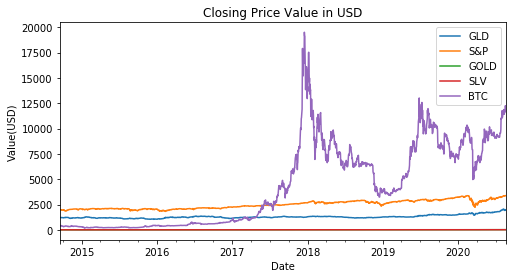

In [33]:
maindf['GLD(USD)'].plot(label='GLD',figsize=(8,4), title='Closing Price Value in USD')
maindf['S&P500(USD)'].plot(label='S&P')
maindf['GOLD(USD)'].plot(label='GOLD')
maindf['SLV(USD)'].plot(label='SLV')
maindf['BTC(USD)'].plot(label='BTC')

plt.xlabel('Date')
plt.ylabel('Value(USD)')
plt.legend();

Welp, it appears that Bitcoin has had such high values and variability that we can't even see the fluxuation of Barrick  Gold Corp (GOLD) or Silver (SLV). Keep in mind that we can always scale the data to make it more observable, but lets save that for the end. Let's use seaborns heatmap correlation instead.

Text(0.5, 1.05, 'Correlation of MainDF Features')

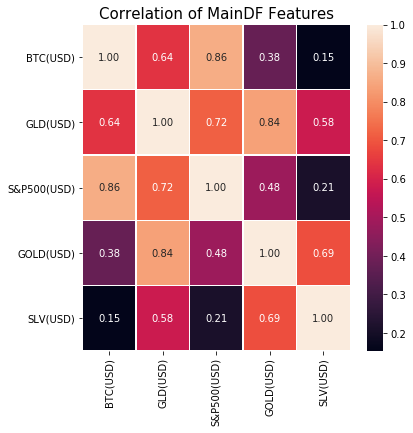

In [34]:
corr = maindf.corr()
plt.figure(figsize = (6,6))
sns.heatmap(corr,
           xticklabels=corr.columns.values,
           yticklabels=corr.columns.values,
           annot=True, fmt='.2f', linewidths=.30)
plt.title('Correlation of MainDF Features', y =1.05,  size=15)

That's a lot easier to read and make note of correlations. It looks like the value of gold (GLD) is significantly correlated with the value of the S&P 500 index (S&P500). In addition, there are several other noteworthy correlations, such as silvers correlation to Barrick Gold Corp and Bitcoins correlation to S&P500.

In [35]:
# Correlation Scores:
print(corr['GLD(USD)'].sort_values(ascending =False), '\n')

GLD(USD)       1.000000
GOLD(USD)      0.839257
S&P500(USD)    0.716838
BTC(USD)       0.636641
SLV(USD)       0.579910
Name: GLD(USD), dtype: float64 



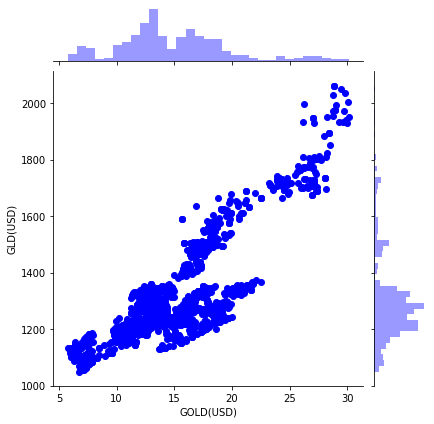

In [36]:
# Using jointplotto visualize relation of GLD with other variables
sns.jointplot(x  = maindf['GOLD(USD)'], y=maindf['GLD(USD)'], color='blue')

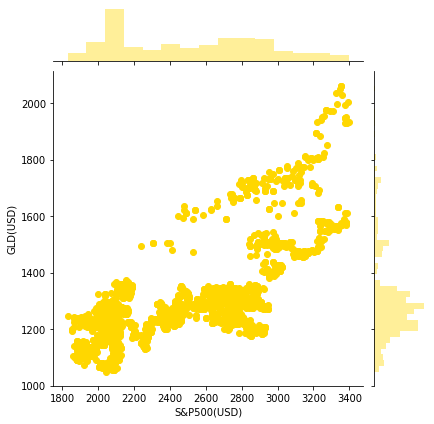

In [37]:
# How about S&P500 and GLD?
sns.jointplot(x= maindf['S&P500(USD)'], y=maindf['GLD(USD)'], color='gold')

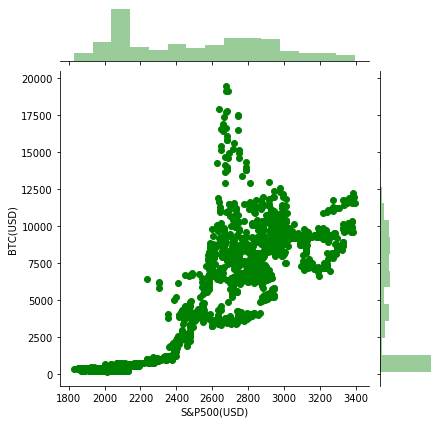

In [38]:
# And just for giggles, how about S&P500 and Bitcoin?
sns.jointplot(x  = maindf['S&P500(USD)'], y=maindf['BTC(USD)'], color='Green')

In [39]:
# Alright, all fun, but lets write the Random Forest Regression test.
# Remember our hypothesis and null hypothesis in order to assign the right
# variables to the dependent and independent variables.

X = maindf[['S&P500(USD)']]
y = maindf[['GLD(USD)']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1995)
print(X_train.shape,  y_train.shape)
print(X_test.shape, y_test.shape)

(1624, 1) (1624, 1)
(542, 1) (542, 1)


In [40]:
# Applying what I learned from my wine linear regression, 
# we are going to work through several models.
rModel = linear_model.LinearRegression(normalize=True)
rModel.fit(X_train, y_train)
print(rModel.score(X_train, y_train))

0.5186231973510473


Currently, the model only explains ~52% of the variation from the mean.

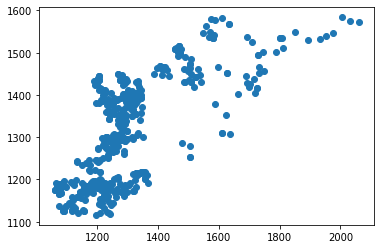

In [41]:
# Got to predict the test set result
y_pred = rModel.predict(X_test)
plt.scatter(y_test, y_pred)

In [42]:
# Now lets move on to our second model, Ordinary Least Squares (OLS)
X = maindf[['GLD(USD)']]

# But now, reassign X the value of adding a constant to it. This is required for OLS Regression.
X = sm.add_constant(X)

In [43]:
# Assign y as before
y=maindf[['S&P500(USD)']]

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1995)

In [44]:
# Create our second regression model
rModel2 = sm.OLS(y_train, X_train)

# Fit the model
rModel2_results = rModel2.fit()

# Review
rModel2_results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:            S&P500(USD)   R-squared:                       0.519
Model:                            OLS   Adj. R-squared:                  0.518
Method:                 Least Squares   F-statistic:                     1748.
Date:                Sun, 06 Dec 2020   Prob (F-statistic):          8.60e-260
Time:                        12:26:36   Log-Likelihood:                -11461.
No. Observations:                1624   AIC:                         2.293e+04
Df Residuals:                    1622   BIC:                         2.294e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const        256.2488     54.034      4.742      0.000     150.264     362.233
GLD(USD)       1.7072      0.041     41.803      0.000       1.627       1.787
==============================================================================
Omnibus:                      365.916   Durbin-Watson:                   1.931
Prob(Omnibus):                  0.000   Jarque-Bera (JB):               79.675
Skew:                           0.212   Prob(JB):                     5.00e-18
Kurtosis:                       2.001   Cond. No.                     1.02e+04
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.02e+04. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

Text(0, 0.5, 'Predicted Values')

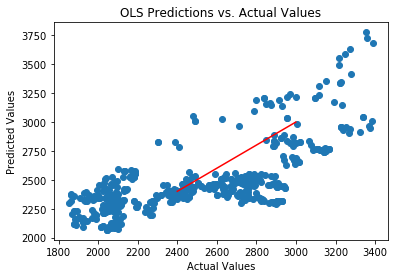

In [45]:
# Predict!
y_pred = rModel2_results.predict(X_test)

plt.scatter(y_test, y_pred)

plt.plot([x for x  in range(2400,3000)], [x for x in range(2400,3000)], color='red')

plt.title('OLS Predictions vs. Actual Values')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')

In [46]:
# ADF Test
print(sm.tsa.stattools.adfuller(maindf['S&P500(USD)']))
print(sm.tsa.stattools.adfuller(maindf['GLD(USD)']))

(-0.966678503857123, 0.7652227681978481, 23, 2142, {'1%': -3.433406561117599, '5%': -2.8628902732885773, '10%': -2.567488819510375}, 19624.312074117315)
(1.5885133621743017, 0.9978227024025917, 24, 2141, {'1%': -3.4334079904672232, '5%': -2.8628909043977235, '10%': -2.567489155536542}, 15915.203329929906)


- ARIMAX is in stats models
- X is usually the exogenous variable
- 3 parameters; AR, I, MAX
- Use the features to predict X


In [58]:
maindf['const'] = 1
model1= sm.OLS(endog=maindf['GLD(USD)'], exog=maindf[['S&P500(USD)','const']].dropna())
results1 = model1.fit()
print(results1.summary())

                            OLS Regression Results                            
Dep. Variable:               GLD(USD)   R-squared:                       0.514
Model:                            OLS   Adj. R-squared:                  0.514
Method:                 Least Squares   F-statistic:                     2287.
Date:                Sun, 06 Dec 2020   Prob (F-statistic):               0.00
Time:                        12:38:59   Log-Likelihood:                -13418.
No. Observations:                2166   AIC:                         2.684e+04
Df Residuals:                    2164   BIC:                         2.685e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
S&P500(USD)     0.3021      0.006     47.826      

In [63]:
maindf['diffGLD'] = maindf['GLD(USD)'].diff()
maindf['diffS&P'] = maindf['S&P500(USD)'].diff()
model2 = sm.OLS(endog=maindf['diffGLD'].dropna(), exog=maindf[['diffS&P','const']].dropna())
results2 = model2.fit()
print(results2.summary())

                            OLS Regression Results                            
Dep. Variable:                diffGLD   R-squared:                       0.003
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     6.571
Date:                Sun, 06 Dec 2020   Prob (F-statistic):             0.0104
Time:                        12:40:25   Log-Likelihood:                -8050.0
No. Observations:                2165   AIC:                         1.610e+04
Df Residuals:                    2163   BIC:                         1.612e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
diffS&P        0.0220      0.009      2.563      0.0

In [66]:
print(sm.tsa.stattools.grangercausalitytests(maindf[['GLD(USD)', 'S&P500(USD)']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=1.0461  , p=0.3065  , df_denom=2162, df_num=1
ssr based chi2 test:   chi2=1.0476  , p=0.3061  , df=1
likelihood ratio test: chi2=1.0473  , p=0.3061  , df=1
parameter F test:         F=1.0461  , p=0.3065  , df_denom=2162, df_num=1
{1: ({'ssr_ftest': (1.0461356785189957, 0.3065131855306691, 2162.0, 1), 'ssr_chi2test': (1.0475873006446002, 0.3060634082406887, 1), 'lrtest': (1.0473339322215907, 0.3061219061737915, 1), 'params_ftest': (1.0461356785192872, 0.30651318553049306, 2162.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002350F8C5348>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000023511134748>, array([[0., 1., 0.]])])}


In [67]:
print(sm.tsa.stattools.grangercausalitytests(maindf[[ 'S&P500(USD)','GLD(USD)']].dropna(),1))


Granger Causality
number of lags (no zero) 1
ssr based F test:         F=6.0242  , p=0.0142  , df_denom=2162, df_num=1
ssr based chi2 test:   chi2=6.0326  , p=0.0140  , df=1
likelihood ratio test: chi2=6.0242  , p=0.0141  , df=1
parameter F test:         F=6.0242  , p=0.0142  , df_denom=2162, df_num=1
{1: ({'ssr_ftest': (6.024229622466091, 0.014189108572175231, 2162.0, 1), 'ssr_chi2test': (6.032588868010679, 0.014044120496233449, 1), 'lrtest': (6.0241997994125995, 0.014111027909282285, 1), 'params_ftest': (6.02422962246339, 0.014189108572198357, 2162.0, 1.0)}, [<statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x000002350F8C5248>, <statsmodels.regression.linear_model.RegressionResultsWrapper object at 0x0000023511134948>, array([[0., 1., 0.]])])}


In [70]:
maindf['lag']=maindf['diffS&P'].shift()
maindf.dropna(inplace=True)
model3=sm.tsa.ARIMA(endog=maindf['GLD(USD)'], exog=maindf[['lag']], order=[1,1,0])
results3=model3.fit()
print(results3.summary())

                             ARIMA Model Results                              
Dep. Variable:             D.GLD(USD)   No. Observations:                 2161
Model:                 ARIMA(1, 1, 0)   Log Likelihood               -8035.662
Method:                       css-mle   S.D. of innovations              9.970
Date:                Sun, 06 Dec 2020   AIC                          16079.324
Time:                        12:52:20   BIC                          16102.037
Sample:                    09-22-2014   HQIC                         16087.631
                         - 08-21-2020                                         
                       coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------
const                0.3143      0.218      1.442      0.149      -0.113       0.742
lag                  0.0225      0.009      2.627      0.009       0.006       0.039
ar.L1.D.GLD(USD)     0.0160 

C:\Users\mccal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
C:\Users\mccal\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
